# Multi-linear Regression Model: Predict bike sharing count

Bike Sharing Dataset 
=

Hadi Fanaee-T

Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Porto
INESC Porto, Campus da FEUP
Rua Dr. Roberto Frias, 378
4200 - 465 Porto, Portugal


Background 
=

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return 
back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return 
back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of 
over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, 
environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by
these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration
of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into
a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important
events in the city could be detected via monitoring these data.


Data Set
=========================================
Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions,
precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to  
the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is 
publicly available in http://capitalbikeshare.com/system-data. We aggregated the data on two hourly and daily basis and then 
extracted and added the corresponding weather and seasonal information. Weather information are extracted from http://www.freemeteo.com. 


### Introduction

Task: Regression model to predict daily bike rental count estimate based on various environmental and seasonal settings:
* The weather season
* Whether given day is a working day or not
* Weather situation in the given day
* Temperature
* Humidity 
* Wind speed

1. Analyse and explore the Bike Sharing rental data
2. Run a Multivariable Regression
3. Evaluate how your model's coefficients and residuals work
4. Use data transformation to improve your model performance
5. Use your model to estimate the rental count of bikes.


### Import statements

In [9]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torcheval.metrics.functional import r2_score
import scipy.stats as stats
import matplotlib.pyplot as plt

### Notebook Presentation

In [10]:
pd.options.display.float_format = '{:,.2f}'.format

### Load data

In [12]:
data = pd.read_csv("data/bike_sharing.csv", index_col = 0)

In [13]:
data.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,6,0,2,0.34,0.36,0.81,0.16,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.36,0.35,0.70,0.25,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.20,0.19,0.44,0.25,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.20,0.21,0.59,0.16,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.23,0.23,0.44,0.19,82,1518,1600


In [14]:
data.columns.values

array(['dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'], dtype=object)

## Exploratory Data Analysis

Text(0.5, 1.0, 'Histogram of count of total bikes')

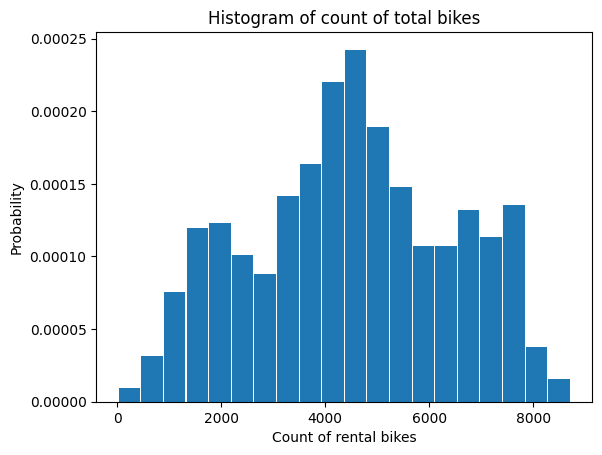

In [16]:
# plot histogram of the response cnt
cnt = data.loc[:, "cnt"]
plt.hist(cnt, density = True, bins = 20, rwidth = 0.95)
plt.ylabel("Probability")
plt.xlabel("Count of rental bikes")
plt.title("Histogram of count of total bikes")

In [7]:
sd = np.std(cnt)
avg = np.mean(cnt)
print("sd: " + str(sd) + "\n" + "mean: " + str(avg) 
      + "\n" + "var: " + str(np.var(cnt)))
print("max: " + str(np.max(cnt)))
print("min: " + str(np.min(cnt)))

sd: 1935.8859561152221
mean: 4504.3488372093025
var: 3747654.4350841474
max: 8714
min: 22


## Comments
Data distribution of the count of total bikes is roughly unimodal and 
symmetric, centered at mean = 4504. Data is spread around the range of 
22 to 8714 with no suspected outliers.<br>
Suitable to fit a linear regression model for cnt since it is quantitative and symmetric.


### Quantitative variables

Text(0.5, 1.0, 'Scatter plot of cnt vs humidity')

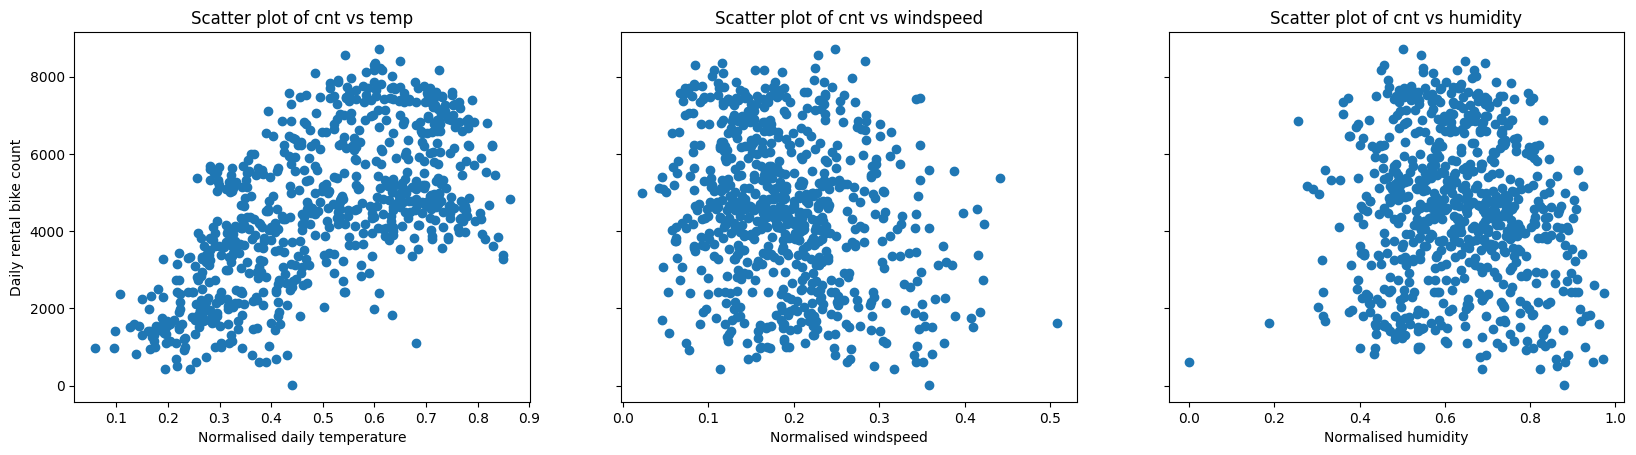

In [8]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, sharey = True)
fig.set_figwidth(20)

# df to vect
temp = data.loc[:, "temp"]
windspeed = data.loc[:, "windspeed"]
humidity = data.loc[:, "hum"]

# count ~ temp
axs[0].scatter(temp, cnt)
axs[0].set_xlabel("Normalised daily temperature")
axs[0].set_ylabel("Daily rental bike count")
axs[0].set_title("Scatter plot of cnt vs temp")

# count ~ windspeed
axs[1].scatter(windspeed, cnt)
axs[1].set_xlabel("Normalised windspeed")
axs[1].set_title("Scatter plot of cnt vs windspeed")

# count ~ humidity
axs[2].scatter(humidity, cnt)
axs[2].set_xlabel("Normalised humidity")
axs[2].set_title("Scatter plot of cnt vs humidity")


In [9]:
print("Correlation coeff for count vs temp: " + str(np.corrcoef(cnt, temp)[0,1]))
print("Correlation coeff for count vs windspeed: " + str(np.corrcoef(cnt, windspeed)[0,1]))
print("Correlation coeff for count vs humidity: " + str(np.corrcoef(cnt, humidity)[0,1]))


Correlation coeff for count vs temp: 0.6274940090334918
Correlation coeff for count vs windspeed: -0.23454499742167007
Correlation coeff for count vs humidity: -0.10065856213715522


## Comments
**temp**: moderate positive association between cnt and temp, seems to be a non-linear association. Variance of temp changes with count.<br>
**windspeed**: weak negative association b/w cnt and windspeed, linear. Variance of winspeed is roughly constant with count.<br>
**humidity**: weak negative association b/w cnt and humidity, linear. Variance of humidity is roughly constant with count.<br><br>
All 3 are potential regressors. As for temp, adding higher order terms might be required during model building. 

### Categorical variables

Categorical variable: weathersit
  Category: 1 has 463 observations
  Category: 2 has 247 observations
  Category: 3 has 21 observations
Categorical variable: season
  Category: 1 has 181 observations
  Category: 2 has 184 observations
  Category: 3 has 188 observations
  Category: 4 has 178 observations
Categorical variable: workingday
  Category: 0 has 231 observations
  Category: 1 has 500 observations


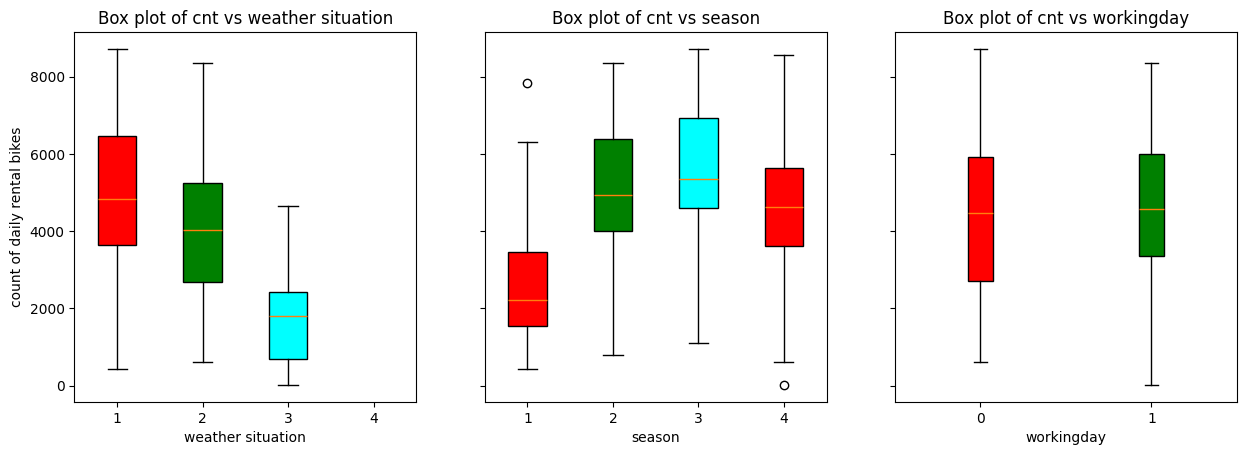

In [10]:
data["weathersit"] = pd.Categorical(data["weathersit"], categories = [1, 2, 3, 4])
data["season"] = pd.Categorical(data["season"], categories = [1, 2, 3, 4])
data["workingday"] = pd.Categorical(data["workingday"])

weathersit = data.loc[:, "weathersit"]
season = data.loc[:, "season"]
workingday = data.loc[:, "workingday"]

fig, axs = plt.subplots(nrows = 1, ncols = 3, sharey = True)
fig.set_figwidth(15)

# takes in a dataframe and column_name and returns a 2D matrix with elements from dataframe["cnt"] column partitioned by
# categories from the categorical column: dataframe[column_name] into the respective columns.
# as a side effect the function also prints out the number of observation per category.
def matrixfy(df, col_name):
    cats = pd.Categorical(df[col_name]).categories
    df = df.groupby(col_name, observed = False)
    arr = [[]] * len(cats)
    print(f"Categorical variable: {col_name}")
    for i, cat in enumerate(cats):
        try: 
            print(f"  Category: {cat} has {len(df.get_group(cat))} observations")  
            arr[i] = np.array(df.get_group(cat)["cnt"], ndmin = 1)
        except KeyError as e:
            continue
    return arr

# alternates color between boxes for each boxplot for the given col_arr color sequence.
# leftmost box takes on col_arr[0], col_arr[1], ..., col_arr[n - 1], col_arr[0], ...
def color_boxplots(bplot, col_arr):
    n = len(col_arr)
    for i, patch in enumerate(bplot["boxes"]):
        patch.set_facecolor(col_arr[i % n])


cols = ["red", "green", "cyan"]
bp_weathersit = axs[0].boxplot(matrixfy(data, "weathersit"), 
                               labels = pd.Categorical(weathersit).categories, 
                               patch_artist = True)
axs[0].set_xlabel("weather situation")
axs[0].set_title("Box plot of cnt vs weather situation")
axs[0].set_ylabel("count of daily rental bikes")
color_boxplots(bp_weathersit, cols)

bp_season = axs[1].boxplot(matrixfy(data, "season"),
                           labels = pd.Categorical(season).categories,
                           patch_artist = True)
axs[1].set_xlabel("season")
axs[1].set_title("Box plot of cnt vs season")
color_boxplots(bp_season, cols)

bp_workingday = axs[2].boxplot(matrixfy(data, "workingday"),
                               labels = pd.Categorical(workingday).categories,
                               patch_artist = True)
axs[2].set_xlabel("workingday")
axs[2].set_title("Box plot of cnt vs workingday")
color_boxplots(bp_workingday, cols)

## Comments
**weathersit**: median decreases from 4844 to 1817 as weather situation gets worse (from weathersit = 1 to 4), with slight decrease in variability and no outliers. There are only 21 observations for category 3 of weathersit, and no data is present for weathersit 4. Therefore some recategorisation may be needed in the future. Variability also changes slightly, with IQR decreasing from 2822 to 2583 to 1719. Potential regressor in the model. <br>
**season**: median increases from  and decreases as the season goes from summer to winter, and the association is not linear due to a change in direction. Variability remains roughly the same, and there are 2 outliers for cnt~season at the value of cnt = 7836 on the right of median for season = 1 (summer), and cnt = 22 on the left of median for season = 4 (winter). Potential regressor in the model. <br>
**workingday**: IQR is higher on a non workingday (3197.0) than on a workingday (2648.5). Medians of both plots are roughly the same, with no outliers.
There is not much association between workingday and cnt, so it might not be a good regressor to use.

## Model building using forward selection

Model M1: cnt ~ temp 

epoch: 10000, loss = 2275695.250000
epoch: 20000, loss = 2272037.750000
epoch: 30000, loss = 2272020.500000
epoch: 40000, loss = 2272020.250000
epoch: 50000, loss = 2272020.250000


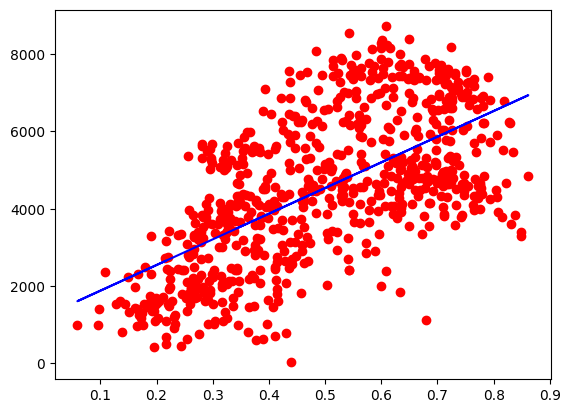

In [11]:
# 1d -> 2d np.array
X = torch.from_numpy(temp.to_numpy().astype(np.float32).reshape(-1, 1))
Y = torch.from_numpy(cnt.to_numpy().astype(np.float32).reshape(-1, 1))
model = nn.Linear(1, 1)

# loss and optimiser
l_rate = 0.005
loss_fn = nn.MSELoss()
optimiser = torch.optim.SGD(model.parameters(), lr = l_rate)

# training phase
N = 50000
for epoch in range(N):
    # forward pass
    y_pred = model(X)
    loss = loss_fn(y_pred, Y)
    # backward pass (backpropagation), calculation of gradients
    loss.backward()

    # update the weights/coefficients
    optimiser.step()

    # flush computed gradients from the loss function

    optimiser.zero_grad()

    if (epoch + 1) % 10000 == 0:
        print(f"epoch: {epoch + 1}, loss = {loss.item():.6f}")

# plot 
predicted = model(X).detach().numpy()
plt.plot(X, Y, "ro")
plt.plot(X, predicted, "b")
plt.show()

### Residual plots

Text(0, 0.5, 'Standardised residuals')

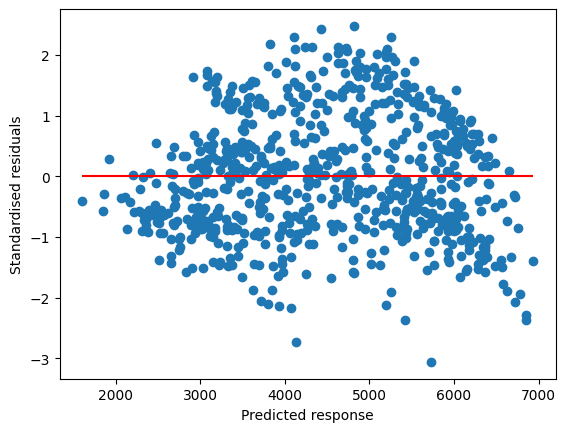

In [12]:
res = (Y - predicted).numpy().flatten()
SR = res / np.std(res)
plt.scatter(predicted, SR)
plt.hlines(0, np.min(predicted), np.max(predicted), colors=["red"])
plt.xlabel("Predicted response")
plt.ylabel("Standardised residuals")

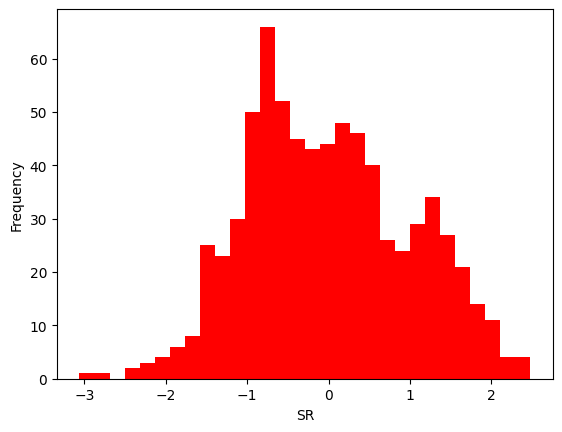

In [13]:
plt.hist(SR, color="red", bins = 30)
plt.xlabel("SR")
h = plt.ylabel("Frequency")

Text(0.5, 1.0, 'Normal probability plot')

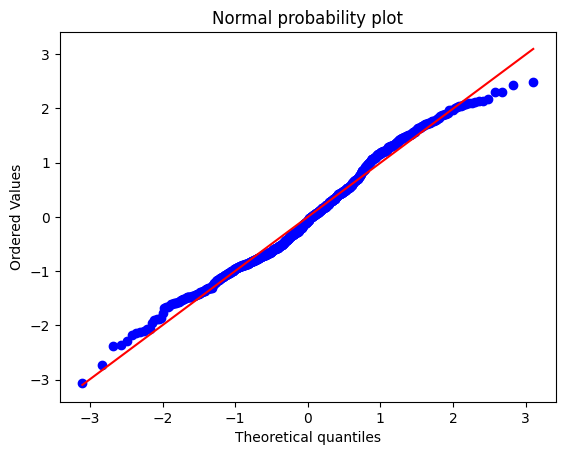

In [14]:
d = stats.probplot(SR, dist="norm", plot = plt)
plt.title("Normal probability plot")

In [30]:
outliers = list(map(lambda e : (e + 1, Y[e]), 
               list(filter(lambda e : SR[e] > 3 or SR[e] < -3, 
                           np.arange(len(SR))))))
print(outliers[:5]) # outlier at cnt = 1115, instant 239
data.loc[239,:]

[(239, tensor([1115.]))]


dteday        2011-08-27
season                 3
yr                     0
mnth                   8
holiday                0
weekday                6
workingday             0
weathersit             1
temp                0.68
atemp               0.64
hum                 0.85
windspeed           0.38
casual               226
registered           889
cnt                 1115
Name: 239, dtype: object

In [16]:
print(f"Y.shape = {Y.shape}, pred.shape = {torch.from_numpy(predicted).shape}")
r2 = r2_score(torch.from_numpy(predicted), Y).item()
R2_adj = 1 - (1 - r2) * (Y.shape[0] - 1) / (Y.shape[0] - 1 - X.shape[1])
R2_adj

Y.shape = torch.Size([731, 1]), pred.shape = torch.Size([731, 1])


0.39291719955344917

## Comments
normal probability plot shows SR having shorter left and right tails than normal. This implies the residuals likely did not come from a normal distribution, violating normality assumption for $\epsilon$. Scatter plot for SR with predicted response $\hat{Y_1}$ violates the constant variance assumption. Histogram conveys a more bimodal shape rather than unimodal, with 1 outlier at cnt = 1115. We will not drop this point as it is neither a typo not currently explainable by external factors. From the R2 score (0.3937), 39.4% of the variation in cnt of rental bikes is explained by M1.

## Adjustments to model
Recategorise weathersit as follows: 1 -> 0 (good weather) and 2,3,4 -> 1 (bad weather). 

In [17]:
data["weathersit"] = pd.Categorical(list(map(lambda ws : 0 if ws == 1 else 1, weathersit)), categories = [0, 1])
gd_weather, bd_weather = matrixfy(data, "weathersit")

Categorical variable: weathersit
  Category: 0 has 463 observations
  Category: 1 has 268 observations


Now that we have sufficiently large sample sizes for each group. Check for the equality of variances via levene's test.

In [18]:
stats.levene(gd_weather, bd_weather)

LeveneResult(statistic=1.0850232905858848e-06, pvalue=0.9991691730268479)

Since the p-value is much larger than 0.05, we do not reject the null hypothesis.
We thus conclude the 2 samples likely come from populations of equal variances.
Perform a 2 sample independent equal var t-test to see if there is a significant difference in the population mean of cnt for good and bad weather:
$$H_0: \mu_{\text{good}} = \mu_{\text{bad}}$$
$$H_1: \mu_{\text{good}} \neq \mu_{\text{bad}}$$

In [19]:
stats.ttest_ind(gd_weather, bd_weather)

TtestResult(statistic=7.056822026227573, pvalue=3.9711363851613115e-12, df=729.0)

Since the p-value is extremely small < 0.05, there is sufficient evidence at 0.05 significance level that the population means of both distributions are different. Thus there is likely a significant association between weathersit and count of bikes, while also ensuring constant variance across both categories. We will use this as a regressor. <br>
### Transformations and additional terms for M2
* $Y$ to $\sqrt{Y}$ to satisfy constant variance
* keep temp ($X_1$) and add higher order terms $X_1^2$ and $X_1^3$
* add humidity ($X_2$) due to association with cnt
* add windspeed ($X_3$) due to association with cnt
* add weathersit ($I(X_4 = 1)$) due to association with cnt
* add interaction term ($X_2 * I(X_4 = 1)$) for weathersit and humidity to account for associations b/w the 2 variables.

## Model 2
$\sqrt{Y} = \beta_0 + \beta_1X_1 + \beta_2X_1^2 + \beta_3X_1^3 + \beta_4X_2 + \beta_5X_3 + \beta_6I(X_4=1) + \beta_7X_2I(X_4=1) + \epsilon$

In [20]:
Y1 = torch.from_numpy(np.sqrt(cnt.to_numpy()).astype(np.float32)).reshape(-1, 1)
X_1 = temp.to_numpy()
X_12 = X_1**2
X_13 = X_1**3
X_2 = humidity.to_numpy()
X_3 = windspeed.to_numpy()
X_4 = weathersit.to_numpy()

X_mat = np.column_stack((X_1, X_12, X_13, X_2, X_3, X_4, X_2 * X_4))
X1 = torch.from_numpy(X_mat.astype(np.float32))

m2 = nn.Linear(X1.shape[1], Y1.shape[1])

l_rate = 0.05
loss_fn = nn.MSELoss()
optimiser = torch.optim.SGD(m2.parameters(), lr = l_rate)

N = 50000
for epoch in range(N):
    # forward pass
    y_pred = m2(X1)

    loss = loss_fn(y_pred, Y1)

    # back prog & update gradients
    loss.backward()
    optimiser.step()
    optimiser.zero_grad()

    if (epoch + 1) % 10000 == 0:
        print(f"epoch: {epoch + 1}, loss: {loss.item()}")

predicted2 = m2(X1).detach().numpy()
print(f"Y1.shape: {Y1.shape}\nX_1.shape: {X1.shape}")

epoch: 10000, loss: 99.1898422241211
epoch: 20000, loss: 95.56828308105469
epoch: 30000, loss: 95.22111511230469
epoch: 40000, loss: 95.18057250976562
epoch: 50000, loss: 95.16893768310547
Y1.shape: torch.Size([731, 1])
X_1.shape: torch.Size([731, 7])


## Residual plots

Text(0, 0.5, 'SR')

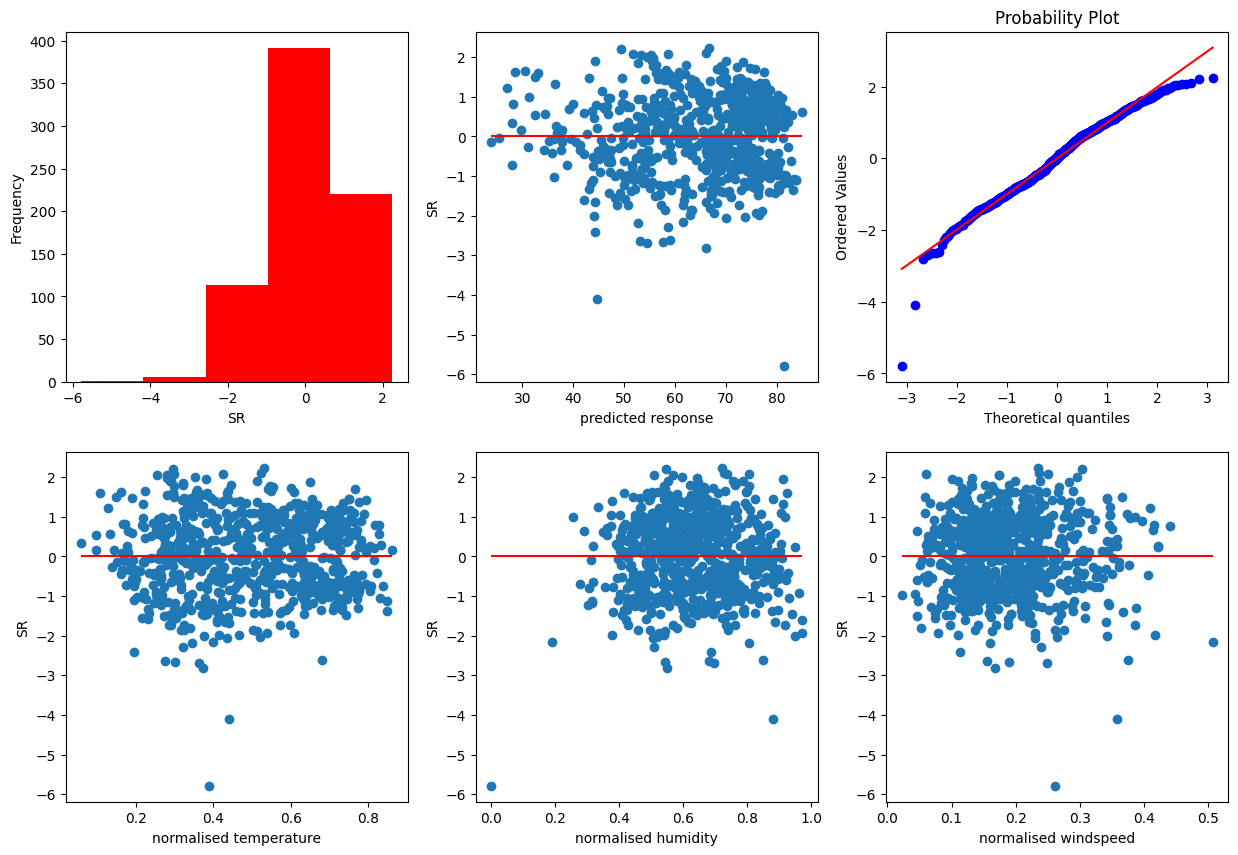

In [21]:
res2 = (Y1 - predicted2).numpy().flatten()
SR2 = res2 / np.std(res2)

fig, axs = plt.subplots(nrows = 2, ncols = 3)
fig.set_figwidth(15)
fig.set_figheight(10)
axs[0, 0].hist(SR2, bins = 5, color = "red")
axs[0, 0].set_xlabel("SR")
axs[0, 0].set_ylabel("Frequency")
axs[0, 1].scatter(predicted2, SR2)
axs[0, 1].set_xlabel("predicted response")
axs[0, 1].set_ylabel("SR")
axs[0, 1].hlines(0, np.min(predicted2), np.max(predicted2), color = "red")
h = stats.probplot(SR2, dist="norm", plot = axs[0, 2])

axs[1, 0].scatter(temp, SR2) 
axs[1, 0].hlines(0, np.min(temp), np.max(temp), color = "red")
axs[1, 0].set_xlabel("normalised temperature")
axs[1, 0].set_ylabel("SR")
axs[1, 1].scatter(humidity, SR2)
axs[1, 1].hlines(0, np.min(humidity), np.max(humidity), color = "red")
axs[1, 1].set_xlabel("normalised humidity")
axs[1, 1].set_ylabel("SR")
axs[1, 2].scatter(windspeed, SR2)
axs[1, 2].hlines(0, np.min(windspeed), np.max(windspeed), color = "red")
axs[1, 2].set_xlabel("normalised windspeed")
axs[1, 2].set_ylabel("SR")

In [22]:
outs2 = list(map(lambda e : (e + 1, Y[e]), 
               list(filter(lambda e : SR2[e] > 3 or SR2[e] < -3, 
                           np.arange(len(SR2))))))
print(outs2)
data.loc[[69,668],:]

[(69, tensor([623.])), (668, tensor([22.]))]


,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
69,2011-03-10,1,0,3,0,4,1,1,0.39,0.39,0.00,0.26,46,577,623
668,2012-10-29,4,1,10,0,1,1,1,0.44,0.44,0.88,0.36,2,20,22


### Outliers
There are 2 outliers from the histogram, at instant = 68 and 668 with cnt = 623 and 222 respectively. Note that instant= 69 is likely a typo since hummidity cant be 0. Likewise, instant 669 occurred during hurricane sandy, which explains the abnormally low cnt. Therefore we consider dropping these outliers since they are unlikely to occur on a normal day.

In [23]:
new_data = data.drop([69, 668])

def attach_some(df):
    global cnt, weathersit, season, workingday, temp, humidity, windspeed
    # DV
    cnt = df.loc[:, "cnt"]  
    # IVs
    weathersit = df.loc[:, "weathersit"]
    season = df.loc[:, "season"]
    workingday = df.loc[:, "workingday"]
    temp = df.loc[:, "temp"]
    humidity = df.loc[:, "hum"]
    windspeed = df.loc[:, "windspeed"]

attach_some(new_data)
len(cnt)

729

In [24]:
# Refit model M2
Y1 = torch.from_numpy(np.sqrt(cnt.to_numpy()).astype(np.float32)).reshape(-1, 1)
X_1 = temp.to_numpy()
X_12 = X_1**2
X_13 = X_1**3
X_2 = humidity.to_numpy()
X_3 = windspeed.to_numpy()
X_4 = weathersit.to_numpy()

X_mat = np.column_stack((X_1, X_12, X_13, X_2, X_3, X_4, X_2 * X_4))
X1 = torch.from_numpy(X_mat.astype(np.float32))

m2 = nn.Linear(X1.shape[1], Y1.shape[1])

l_rate = 0.05
loss_fn = nn.MSELoss()
optimiser = torch.optim.SGD(m2.parameters(), lr = l_rate)

N = 50000
for epoch in range(N):
    # forward pass
    y_pred = m2(X1)

    loss = loss_fn(y_pred, Y1)

    # back prog & update gradients
    loss.backward()
    optimiser.step()
    optimiser.zero_grad()

    if (epoch + 1) % 10000 == 0:
        print(f"epoch: {epoch + 1}, loss: {loss.item()}")

predicted2 = m2(X1).detach().numpy()
print(f"Y1.shape: {Y1.shape}\nX_1.shape: {X1.shape}")

epoch: 10000, loss: 93.31483459472656
epoch: 20000, loss: 89.31680297851562
epoch: 30000, loss: 88.92904663085938
epoch: 40000, loss: 88.88534545898438
epoch: 50000, loss: 88.87466430664062
Y1.shape: torch.Size([729, 1])
X_1.shape: torch.Size([729, 7])


## Residual plots

Text(0, 0.5, 'SR')

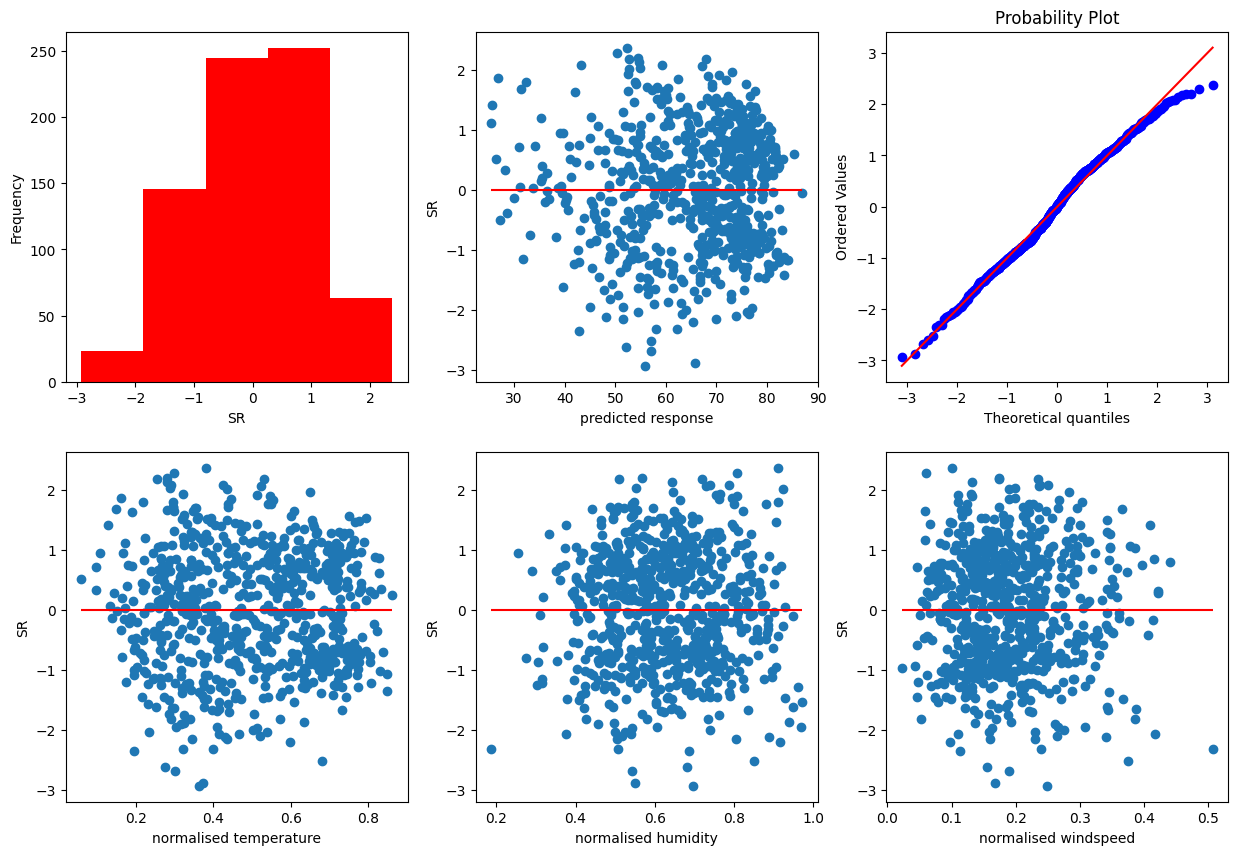

In [25]:
res2 = (Y1 - predicted2).numpy().flatten()
SR2 = res2 / np.std(res2)

fig, axs = plt.subplots(nrows = 2, ncols = 3)
fig.set_figwidth(15)
fig.set_figheight(10)
axs[0, 0].hist(SR2, bins = 5, color = "red")
axs[0, 0].set_xlabel("SR")
axs[0, 0].set_ylabel("Frequency")
axs[0, 1].scatter(predicted2, SR2)
axs[0, 1].set_xlabel("predicted response")
axs[0, 1].set_ylabel("SR")
axs[0, 1].hlines(0, np.min(predicted2), np.max(predicted2), color = "red")
h = stats.probplot(SR2, dist="norm", plot = axs[0, 2])

axs[1, 0].scatter(temp, SR2) 
axs[1, 0].hlines(0, np.min(temp), np.max(temp), color = "red")
axs[1, 0].set_xlabel("normalised temperature")
axs[1, 0].set_ylabel("SR")
axs[1, 1].scatter(humidity, SR2)
axs[1, 1].hlines(0, np.min(humidity), np.max(humidity), color = "red")
axs[1, 1].set_xlabel("normalised humidity")
axs[1, 1].set_ylabel("SR")
axs[1, 2].scatter(windspeed, SR2)
axs[1, 2].hlines(0, np.min(windspeed), np.max(windspeed), color = "red")
axs[1, 2].set_xlabel("normalised windspeed")
axs[1, 2].set_ylabel("SR")

In [26]:
print(Y1.shape)
print(torch.from_numpy(predicted2).shape)
target = Y1
inpt = torch.from_numpy(predicted2)
r2 = r2_score(inpt, target).item()
R2_adj = 1 - (1 - r2) * (Y1.shape[0] - 1) / (Y1.shape[0] - 1 - X1.shape[1])
R2_adj

torch.Size([729, 1])
torch.Size([729, 1])


0.6281915960960018

## Final Comments
M2 is adequate now that it satisfies the constant variance assumption from the various residual plots of SR against cnt, hum, windspeed and temp.<br>
From the qq plot and histogram, we see both tails are normal, therefore satisfying the normality assumption.
Additionally it has a higher adjusted r2 score of 0.628 > 0.393, therefore a better goodness of fit as 62.8% of the variation in cnt is now explained by M2.

In [31]:
print(m2.weight)
print(m2.bias)

Parameter containing:
tensor([[ 158.4791,   -5.5538, -125.9449,  -22.1156,  -41.6096,   19.7313,
          -31.6135]], requires_grad=True)
Parameter containing:
tensor([33.0736], requires_grad=True)


### Final Model: M2
fitted model is given by the following equation:<br>
$$\hat{\sqrt{Y}} = 33.07 + 158X_1-5.55X_1^2-126X_1^3-22.1X_2-41.6X_3-19.7I(X_4=1)+31.6X_2I(X_4=1)$$